In [ ]:
!pip install langchain
!pip install unstructured
!pip install pdf2image
!pip install chromadb
!pip install openai
!pip install tiktoken

In [107]:
import langchain.document_loaders as loaders
import matplotlib.pyplot as plt
from langchain.text_splitter import RecursiveCharacterTextSplitter
import os

from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.document_loaders import TextLoader
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI

## Provide OpenAI Api Key

In [145]:
os.environ["OPENAI_API_KEY"] = ## YOUR OpenAI API Key Here

## Load Source Documents

In [17]:
# load data
files = loaders.DirectoryLoader("./kararlar/", glob="*.txt").load()

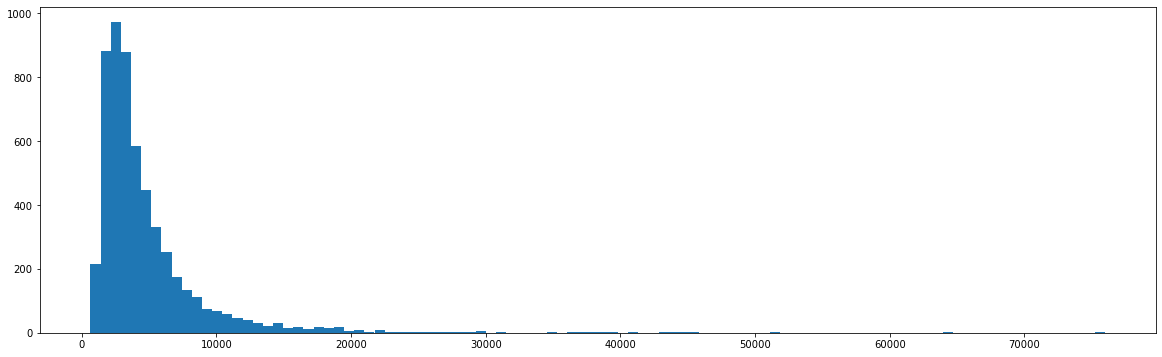

In [48]:
plt.figure(figsize=(20,6))
plt.hist([len(f.page_content) for f in files ], bins=100)
plt.show()  

In [49]:
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 2000,
    chunk_overlap  = 100,
    length_function = len,
)

In [50]:
texts = text_splitter.create_documents([f.page_content for f in files])

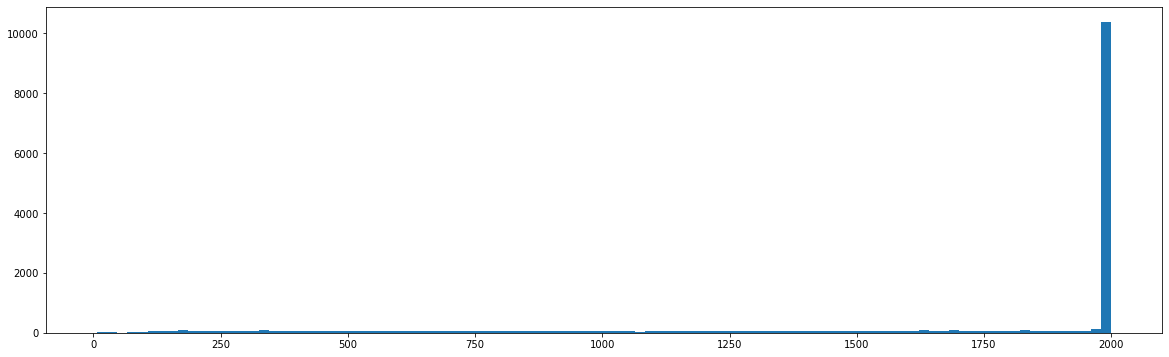

In [51]:
plt.figure(figsize=(20,6))
plt.hist([len(f.page_content) for f in texts ], bins=100)
plt.show()  

## Create Index

In [79]:
persist_directory = './chroma_db_store'

embedding = OpenAIEmbeddings()
vectordb = Chroma.from_documents(documents=texts, embedding=embedding, persist_directory=persist_directory)

In [90]:
sum([len(t.page_content.split()) for t in texts])

3304987

In [91]:
vectordb.persist()
vectordb = None

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

## Load Local Index

In [92]:
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding)

## Similarity Search

In [103]:
docs = vectordb.similarity_search_with_score("ibraname ile savunma çelişkili bulunduğu durumda ne yapılır?")

In [ ]:
docs

[(Document(page_content='bulunan, imzası inkar edilmeyen ve irade fesadı altında düzenlendiği kanıtlanmayan ibranamenin, savunmayla da çelişmemesi karşısında ibraname geçerli kabul edilerek bu alacakların reddine karar verilmesi gerekirken kabulü isabetsiz olup bozmayı gerektirmiştir.F) Sonuç:Temyiz olunan kararın, yukarıda yazılı sebepten dolayı BOZULMASINA, peşin alınan temyiz harcının istek halinde ilgiliye iadesine 07.02.2013 tarihinde oybirliğiyle karar verildi. **2013/5 2013/5**', metadata={}),
  0.3107708692550659),
 (Document(page_content='sebebinin diğer bir anlatımla iddianın kanıtlanması amacıyla söylendiği, iddia ve savunma sınırları içinde kaldığı anlaşılmış olup davacının kişilik haklarına saldırı olarak değerlendirilmesi mümkün değildir. Bu itibarla davanın reddine karar verilmesi gerekirken yazılı şekilde hüküm kurulması doğru görülmediğinden kararın bozulması gerekmiştir.SONUÇ: Temyiz olunan kararın yukarıda gösterilen nedenlerle BOZULMASINA ve peşin alınan harcın iste

## Question Answering

In [146]:
qa = RetrievalQA.from_chain_type(llm=OpenAI(), chain_type="map_reduce", retriever=vectordb.as_retriever())

query = "ibraname ile savunma çelişkili bulunduğu durumda ne yapılır?"
qa.run(query)

' Dosya içinde bulunan bilirkişi raporu bir değerlendirmeye tabi tutularak davaya konu tazminat isteklerinin kabulü gerekirken, mahkemece her iki isteğin de ibraname sebebiyle reddi hatalı olmuştur.'

In [117]:
qa = RetrievalQA.from_chain_type(llm=OpenAI(), chain_type="stuff", retriever=vectordb.as_retriever())

query = "ibraname ile savunma çelişkili bulunduğu durumda ne yapılır?"
qa.run(query)


' Ibraname değerlendirilerek davaya konu tazminat isteklerinin kabulü gerekir.'

In [118]:
qa = RetrievalQA.from_chain_type(llm=OpenAI(), chain_type="stuff", retriever=vectordb.as_retriever())

query = "ibraname ile savunma çelişkili bulunduğu durumda ibraname geçerli midir?"
qa.run(query)


' Hayır, savunma ile çelişen ibranamenin geçersiz olduğu kabul edilmelidir.'

In [120]:
qa = RetrievalQA.from_chain_type(llm=OpenAI(), chain_type="stuff", retriever=vectordb.as_retriever())

query = "Bordroda fazla mesai ödemesi görünüyor. Çalışan bordroyu bu şekilde imzalamış Fakat ödemeler eksik. Çalışan daha fazla ödeme alabilir mi? Kısa yanıt istiyorum."
qa.run(query)


' Hayır, çalışan daha fazla ödeme alamaz. Bordroda fazla mesai ödemesi görünüyorsa, çalışanın daha fazla çalışma yaptığını ispatlaması gerekmektedir.'

In [123]:
qa = RetrievalQA.from_chain_type(llm=OpenAI(), chain_type="stuff", retriever=vectordb.as_retriever())

query = "Bordroda fazla mesai ödemesi görünmüyor. Çalışan bordroyu bu şekilde imzalamış. Çalışan fazla mesai ödemesi talebinde bulunabilir mi?"
qa.run(query)

' İmzalı ücret bordrolarında fazla çalışma ücreti ödendiği anlaşılıyorsa, işçi tarafından gerekçe daha fazla çalışma yaptığının ileri sürülmesi mümkün değildir. Ancak, işçinin fazla çalışma alacağının daha fazla olduğu yönündeki ihtirazi kaydının bulunması halinde, bordroda görünenden daha fazla çalışmanın ispatı her türlü delille söz konusu olabilir.'

In [144]:
qa = RetrievalQA.from_chain_type(llm=OpenAI(), chain_type="stuff", retriever=vectordb.as_retriever())

query = "Bordroda fazla mesai ödemesi görünmüyor. Çalışan bordroyu bu şekilde imzalamış. Çalışan fazla mesai ödemesi talebinde bulunabilir mi?"
qa.run(query)

' Çalışanın bordroda gösterilenden daha fazla çalışma yaptığını yazılı delille kanıtlaması gerekir. Bordroda imzalı ve ihtirazi kayıtsız olması durumunda, çalışanın her ay değişik miktarlarda ücret ödemelerinin banka kanalıyla yapılması durumunda, ihtirazi kayıt ileri sürülmemiş olması, ödenenin üzerinde fazla çalışma yapıldığının yazılı delille ispatlanması gerektiği sonucunu doğurmaktadır.'

In [141]:
qa = RetrievalQA.from_chain_type(llm=OpenAI(), chain_type="stuff", retriever=vectordb.as_retriever())

query = "Bordroda fazla mesai ödemesi yok. Fazla mesai ödemesi istenebilir mi?"
qa.run(query)

' Evet, fazla mesai ödemesi istenebilir. Ancak, fazla mesai yapıldığının ve hafta tatillerinde çalışıldığının somut ve net olarak ispatlanması gerekir. Bu konuda varsayıma dayanılarak hüküm kurulamaz. Dosyada bulunan imzalı bordrolara karşı davacının itirazı bulunmuyorsa, bordrolara karşı davacının itirazı bulunmuyorsa, bordrolardaki ücretlere itibar edilerek işçilik hakları hesaplanmalıdır.'